# Análisis estadístico del espesor del lente de agua dulce por método


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind, shapiro, levene, probplot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [5]:
## 1. Cargar los datos
df = pd.read_csv(r"data/statistics_profiles_methods.csv")
df.head()


,id,method,fwl_thickness,mean,std,cv,min,max,median,25%,50%,75%,iqr
0,AW1D_YSI_20230826,IC,16.317073,1575.951416,120.598105,0.076524,1302.0,2004.80,1525.15,1515.600,1525.15,1605.90,90.300
1,AW1D_YSI_20230826,BIC,17.169116,1648.868238,354.147610,0.214782,1302.0,3793.70,1530.20,1515.800,1530.20,1660.40,144.600
2,AW1D_YSI_20230826,DGH,16.386594,1577.652161,123.382048,0.078206,1302.0,2015.70,1525.50,1515.600,1525.50,1608.00,92.400
3,AW2D_YSI_20230815,IC,9.563224,425.690598,25.702609,0.060379,389.0,478.15,424.85,404.250,424.85,449.20,44.950
4,AW2D_YSI_20230815,BIC,9.907636,428.632290,30.027030,0.070053,389.0,562.50,425.60,405.125,425.60,450.65,45.525


# Cargar datos

## 2. Justificación del uso de ANOVA

Usamos ANOVA cuando queremos comparar **más de dos grupos** (en este caso, métodos IC, BIC, DGH) en cuanto a una variable numérica (`fwl_thickness`).  
ANOVA evalúa si las medias de los grupos son estadísticamente diferentes entre sí.

### Supuestos de ANOVA:
- Independencia de los datos.
- Normalidad de los datos dentro de cada grupo.
- Homogeneidad de varianzas entre grupos.

---

Shapiro IC: ShapiroResult(statistic=np.float64(0.9596726342821538), pvalue=np.float64(0.40799306121967827))
Shapiro DGH: ShapiroResult(statistic=np.float64(0.9862530249905028), pvalue=np.float64(0.9754272275464707))
Levene Test: LeveneResult(statistic=np.float64(0.32460761708131425), pvalue=np.float64(0.571508735596739))
t-test: TtestResult(statistic=np.float64(0.449184337597261), pvalue=np.float64(0.6553203275503601), df=np.float64(48.0))


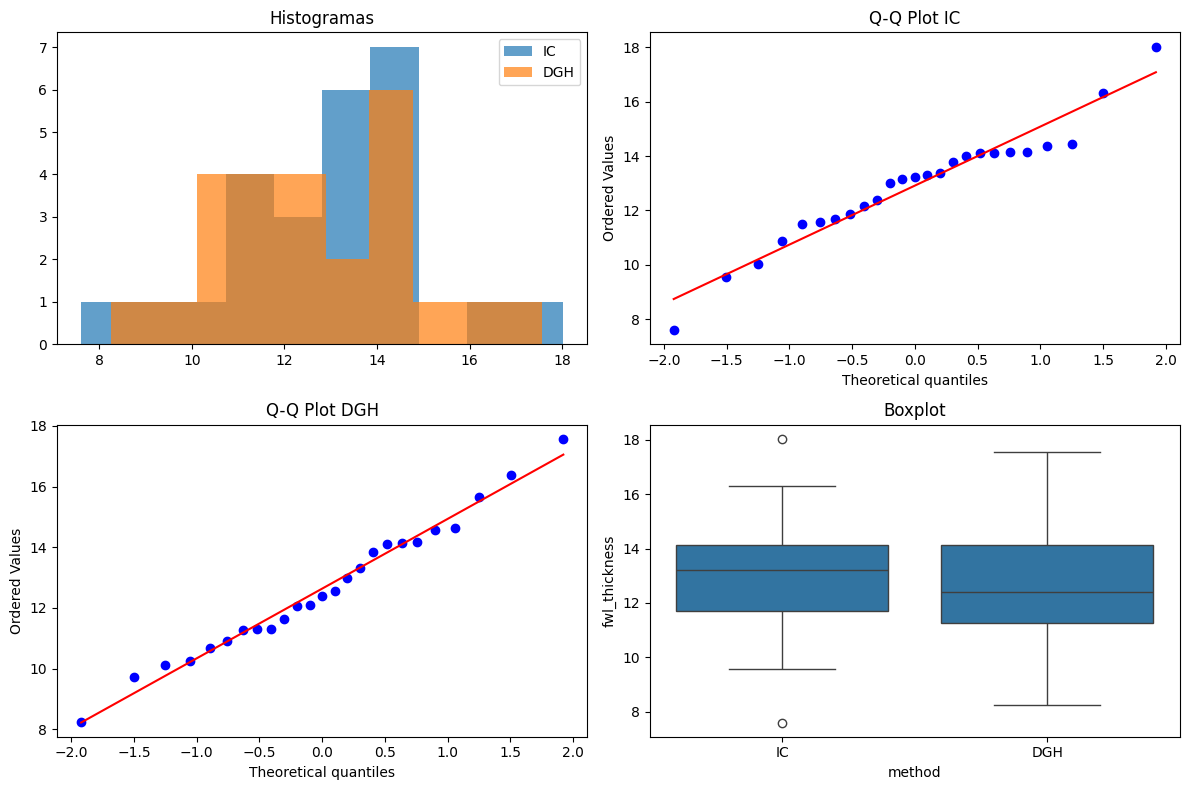

ANOVA global: F_onewayResult(statistic=np.float64(0.12215528267576567), pvalue=np.float64(0.8851939534739428))
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   BIC    DGH  -0.2534 0.9124 -1.7392 1.2324  False
   BIC     IC   0.0232 0.9992 -1.4626  1.509  False
   DGH     IC   0.2766 0.8965 -1.2092 1.7624  False
---------------------------------------------------


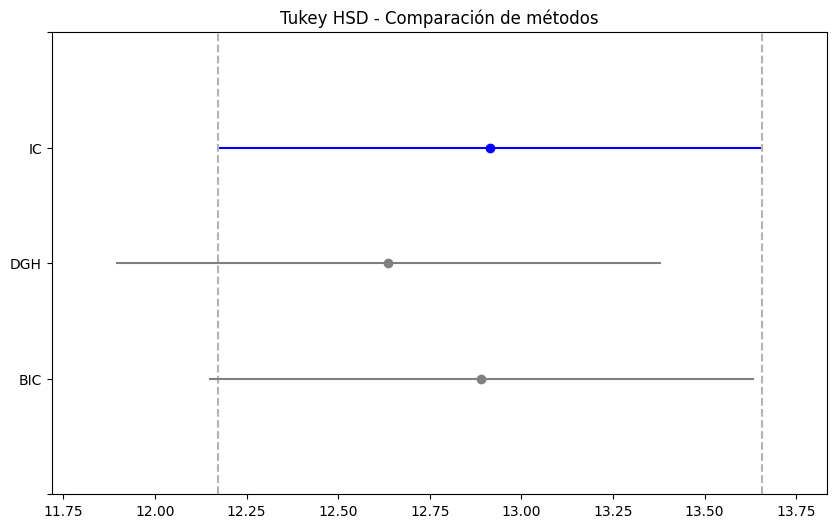

ANOVA pozos seleccionados: F_onewayResult(statistic=np.float64(0.004941383435256857), pvalue=np.float64(0.995071704782041))
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   BIC    DGH  -0.0474 0.9989 -2.6779 2.5832  False
   BIC     IC   0.0579 0.9984 -2.5726 2.6885  False
   DGH     IC   0.1053 0.9946 -2.5252 2.7358  False
---------------------------------------------------


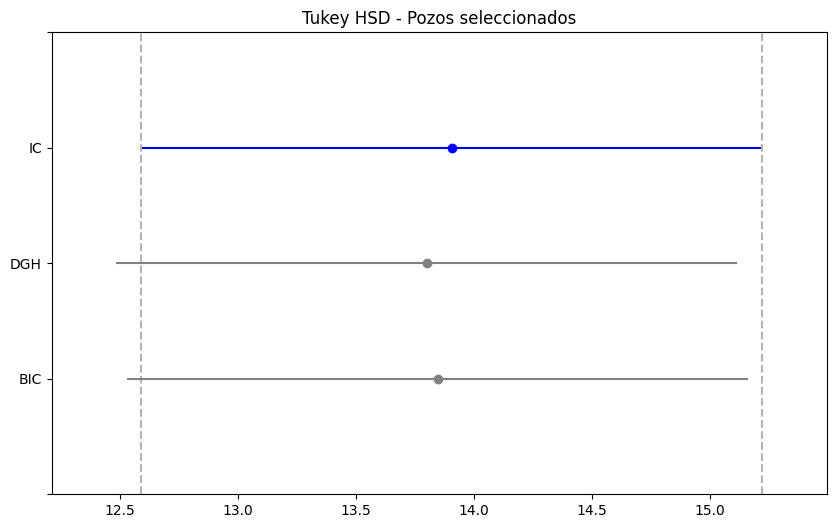

In [6]:


## 3. Verificación de supuestos para ANOVA (IC vs DGH)

df_ic_dgh = df[df['method'].isin(['IC', 'DGH'])]

# Normalidad
shapiro_ic = shapiro(df_ic_dgh[df_ic_dgh['method'] == 'IC']['fwl_thickness'])
shapiro_dgh = shapiro(df_ic_dgh[df_ic_dgh['method'] == 'DGH']['fwl_thickness'])

# Homogeneidad de varianzas
levene_test = levene(
    df_ic_dgh[df_ic_dgh['method'] == 'IC']['fwl_thickness'],
    df_ic_dgh[df_ic_dgh['method'] == 'DGH']['fwl_thickness']
)

print("Shapiro IC:", shapiro_ic)
print("Shapiro DGH:", shapiro_dgh)
print("Levene Test:", levene_test)

## 4. Prueba t de Student + Q-Q Plot + Histogramas


# Prueba t
t_test = ttest_ind(
    df_ic_dgh[df_ic_dgh['method'] == 'IC']['fwl_thickness'],
    df_ic_dgh[df_ic_dgh['method'] == 'DGH']['fwl_thickness'],
    equal_var=True
)
print("t-test:", t_test)

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].hist(df_ic_dgh[df_ic_dgh['method'] == 'IC']['fwl_thickness'], alpha=0.7, label='IC')
axes[0, 0].hist(df_ic_dgh[df_ic_dgh['method'] == 'DGH']['fwl_thickness'], alpha=0.7, label='DGH')
axes[0, 0].set_title('Histogramas')
axes[0, 0].legend()

probplot(df_ic_dgh[df_ic_dgh['method'] == 'IC']['fwl_thickness'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot IC')

probplot(df_ic_dgh[df_ic_dgh['method'] == 'DGH']['fwl_thickness'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot DGH')

sns.boxplot(data=df_ic_dgh, x='method', y='fwl_thickness', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot')

plt.tight_layout()
plt.show()


## 5. Pruebas ANOVA para todos los métodos y todos los pozos

anova_all = f_oneway(
    df[df['method'] == 'IC']['fwl_thickness'],
    df[df['method'] == 'BIC']['fwl_thickness'],
    df[df['method'] == 'DGH']['fwl_thickness']
)
print("ANOVA global:", anova_all)

# Tukey HSD
tukey = pairwise_tukeyhsd(endog=df['fwl_thickness'], groups=df['method'], alpha=0.05)
print(tukey.summary())

# Gráfico
tukey.plot_simultaneous(comparison_name='IC')
plt.title('Tukey HSD - Comparación de métodos')
plt.show()

## 6. Repetir análisis para pozos específicos

selected_ids = [
    "AW1D_YSI_20230826", "AW2D_YSI_20230815", "AW5D_YSI_20230824",
    "AW6D_YSI_20230815", "BW5D_YSI_20230822", "BW8D_YSI_20230823",
    "LRS33D_YSI_20230822", "LRS75D_YSI_20230819", "LRS81D_YSI_20230823",
    "LRS90D_YSI_20230827"
]

df_selected = df[df['id'].isin(selected_ids)]

anova_selected = f_oneway(
    df_selected[df_selected['method'] == 'IC']['fwl_thickness'],
    df_selected[df_selected['method'] == 'BIC']['fwl_thickness'],
    df_selected[df_selected['method'] == 'DGH']['fwl_thickness']
)
print("ANOVA pozos seleccionados:", anova_selected)

tukey_selected = pairwise_tukeyhsd(endog=df_selected['fwl_thickness'], groups=df_selected['method'], alpha=0.05)
print(tukey_selected.summary())

tukey_selected.plot_simultaneous(comparison_name='IC')
plt.title('Tukey HSD - Pozos seleccionados')
plt.show()
